## Imports

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score


import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

## Global variables

In [288]:
#features we will keep for training and predicting 
#obtained through features of importance when models initially trained
col_try = ['sales', 
           's_lag_1','s_lag_2','s_lag_3', 's_lag_4', 's_lag_5','s_lag_6','s_lag_7', #sales lag features
           'p_lag_6',                                                               #promotion lag features
           'Min_7_days',                                                            #minimum sales features
           'STD_7_days', 'STD_15_days', 'STD_30_days',                              #standard sales deviation features
           'MA_3_days', 'MA_7_days', 'MA_15_days', 'MA_30_days',                    #moving average features
           'prod_LIQUOR,WINE,BEER', 'prod_HOME CARE',                               #product features
           'day_4', 'day_5',                                                        #day in week features
           'dnbr_1',  'dnbr_31',                                                    #day in month features
           'month_1','month_8','month_12',                                          #month in year features
           'store_20'                                                               #store number features
          ]
#useful for navigating the data during training
length_of_daily_sequence = 660

#use to select data from a certain period
date_to_select = '2016-01-01'

## Define helper functions for the pipeline

## 1. Data Processing

In [156]:
#here we should retrieve the data we need either for training or "production"
def load_data(training = True):

        if(training):
            print("loading data for training")
            dataset = pd.read_csv("train/train.csv")
            
        else: 
            #do data extraction
            print("extracting data from database")

        length_of_daily_sequence, dataset  = do_conversion_and_basic_check(dataset)
    
        return dataset

In [157]:
def do_conversion_and_basic_check(dataset):
        #convert column to workable format
        dataset['onpromotion']= dataset['onpromotion'].astype(float)
        dataset['date']= pd.to_datetime(dataset['date'])

        #print some basics:
        number_of_products = len(dataset['family'].unique())
        number_of_stores   = len(dataset['store_nbr'].unique())
        number_of_days     = len(dataset['date'].unique())
        length_of_data     = len(dataset)
        length_of_daily_sequence = number_of_products*number_of_stores
        number_of_sequence = len(dataset)/length_of_daily_sequence
        
        print('length of daily sequence:',length_of_daily_sequence)
        print('number of sequence:',number_of_sequence)
        print('number of products:',number_of_products)
        print('number of stores:', number_of_stores)
        print('number of days:', number_of_days)
        print('data set length:', length_of_data)
        print('earliest sales:', dataset['date'].min())
        print('latest sales:', dataset['date'].max())

        #return number of rows per day, useful to navigate the dataframe
        return length_of_daily_sequence, dataset

In [158]:
def build_naive_model(dataset):
        #we make as a prediction of sales for today yesterday's sales
        dataset['Naive prediction'] = dataset['sales']
        return dataset

In [159]:
def build_target(dataset, length_of_daily_sequence):
        #each actual sale as 'target' is next day's sale we notice
        #we need to skip a full day sales sequence to obtain the next day's sale per shop and product type
        dataset['target'] = dataset['sales'].shift(-length_of_daily_sequence)

        #remove the first sequence for which we cannot have past data to construct the targets
        dataset = dataset.dropna()
        dataset = dataset.reset_index(drop = True)

        print("finished targets")
        return dataset

In [336]:
#for Naive model
#y_pred  = dataset[dataset['date']>=from_date]['Naive prediction'].values
#y_actual = dataset[dataset['date']>=from_date]['target'].values

#def compute_rmsle(y_pred, y_actual, from_date='2016-01-01'):
def compute_rmsle(y_pred, y_actual):
    # Calculate the Root Mean Squared Logarithmic Error (RMSLE) for each target variable
    rmsle = np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_actual)), axis=0) )
    print("The RMSLE is:", round(rmsle,5) )


In [161]:
def cap_outliers_pos(dataset):
    '''we may or may not process the outliers. Depending on the model used, XGB being relatively robust to outliers
    in regard of the disproportionate skew of sales to 0, we prefer to compute the average and standard deviation on
    strictly positive sales
    we ignore the shop specificities here, in the future, we might do this capping at shop level
    we prefer to cap rather than remove the data point to maintain consistency of the data organization
    '''
    for i in dataset['family'].unique():
        max = dataset.loc[(dataset['family'] ==i)&(dataset['sales'] !=0),'sales'].mean()+ 3 * dataset.loc[(dataset['family'] ==i)&(dataset['sales'] !=0),'sales'].std()

        dataset.loc[dataset['family'] == i, 'sales'] = dataset[dataset['family'] == i]['sales'].clip(upper=max)
        dataset.loc[dataset['family'] == i, 'Naive prediction'] = dataset[dataset['family'] == i]['Naive prediction'].clip(upper=max)
        dataset.loc[dataset['family'] == i, 'target'] = dataset[dataset['family'] == i]['target'].clip(upper=max)

    print("finished capping")
    return dataset


In [162]:
def draw_ROC(y_test, y_pred_prob):
        '''useful curve to assess the binary classification model'''
        # Compute ROC curve
        fpr,tpr,thresholds = roc_curve(y_test, y_pred_prob)
        
        # Compute ROC AUC score
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        
        # Plot ROC curve
        plt.figure(figsize=(8, 4))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.grid()
        plt.show()

In [242]:
def training_selector(dataset):
    '''indicate for training purpose whether next day sales is zero or strictly positive
       if 0 we train the classificator if not zero we train the regressor with the data point
    '''
    targets = dataset['target']
    dataset["C0_class"] = 0
    dataset.loc[(dataset['target'] ==0) ,'C0_class'] = 1

    return dataset,targets


## 2. Feature engineering

Once we have identified the features of importance, we can simplify the feature creation and just compute the one that we will use instead
of creating the full series

In [164]:
def lag_features(dataset,length_of_daily_sequence):
    '''build lag features from sales and promotions for 7 days'''
    for i in range(1,8):
        sales_lag_d = 's_lag_'+ str(i)
        prom_lag_d = 'p_lag_'+ str(i)
        dataset[sales_lag_d] = dataset['sales'].shift(i*length_of_daily_sequence)
        dataset[prom_lag_d] = dataset['onpromotion'].shift(i*length_of_daily_sequence)

    return dataset


In [165]:
def moving_average_features(dataset):
    '''compute the moving average per products per store
       for 3, 7, 15 and 30 days'''
    for rolling_window_size in [3,7,15,30]:
        col_name = "MA_"+str(rolling_window_size) + "_days"
        for i in dataset['store_nbr'].unique():
            for j in dataset['family'].unique():
                dataset.loc[(dataset['family'] ==j) & (dataset['store_nbr'] ==i),col_name] = \
                dataset.loc[(dataset['family'] ==j) & (dataset['store_nbr'] ==i),'sales'].rolling(window=rolling_window_size).mean()

    return dataset

In [166]:
def standard_deviation_features(dataset):
    '''compute the standard deviation per products per store
    for 7, 15 and 30 days'''
    for rolling_window_size in [7,15,30]:
        col_name = "STD_"+str(rolling_window_size) + "_days"
        for i in dataset['store_nbr'].unique():
            for j in dataset['family'].unique():
                dataset.loc[(dataset['family'] ==j) & (dataset['store_nbr'] ==i),col_name] = \
                dataset.loc[(dataset['family'] ==j) & (dataset['store_nbr'] ==i),'sales'].rolling(window=rolling_window_size).std()

    return dataset

In [167]:
def min_features(dataset):
    '''compute the minimum sales per products per store
       for 3, 7, 15 and 30 days'''
    for rolling_window_size in [3,7,15,30]:
        col_name = "Min_"+str(rolling_window_size) + "_days"
        for i in dataset['store_nbr'].unique():
            for j in dataset['family'].unique():
                dataset.loc[(dataset['family'] ==j) & (dataset['store_nbr'] ==i),col_name] = \
                dataset.loc[(dataset['family'] ==j) & (dataset['store_nbr'] ==i),'sales'].rolling(window=rolling_window_size).min()

    return dataset

In [168]:
def max_features(dataset):
    '''compute the maximum sales per products per store
       for 3, 7, 15 and 30 days'''
    for rolling_window_size in [3,7,15,30]:
        col_name = "Max_"+str(rolling_window_size) + "_days"
        for i in dataset['store_nbr'].unique():
            for j in dataset['family'].unique():
                dataset.loc[(dataset['family'] ==j) & (dataset['store_nbr'] ==i),col_name] = \
                dataset.loc[(dataset['family'] ==j) & (dataset['store_nbr'] ==i),'sales'].rolling(window=rolling_window_size).max()

    return dataset

In [169]:
def temporal_features(date_object):

    day_in_week =  date_object.weekday()
    #year       =  date_object.year

    # Get the day number in month
    day_number = date_object.timetuple().tm_mday

    # Get the month
    month = date_object.month
    
    #return year,week_number,day_in_week
    return day_in_week, day_number , month

In [170]:
def one_hot_encode_categorical_features(dataset):
    dataset = pd.get_dummies(dataset, columns=['store_nbr', 'family','day_in_week','day_in_month', 'month'], prefix=['store', 'prod', 'day', 'dnbr','month'], dtype = int)
    return dataset

In [182]:
def build_features(dataset,length_of_daily_sequence):
    #we may want to customize the feature builing
    print("Starting feature engineering")
    
    dataset = lag_features(dataset,length_of_daily_sequence)
    print("finished lags")

    dataset = moving_average_features(dataset)        
    print("finished moving averages")

    #remove the initial rows for which we don't have moving averages
    dataset = dataset.dropna()
    dataset = dataset.reset_index(drop = True)

    dataset = standard_deviation_features(dataset)
    print("finished standard deviations")

    dataset = min_features(dataset)
    print("finished mins")

    dataset = max_features(dataset)
    print("finished maxs") 

    dataset[['day_in_week','day_in_month', 'month']] = dataset['date'].apply(lambda x: pd.Series(temporal_features(x)))
    print("finished temporal features")

    dataset = one_hot_encode_categorical_features(dataset)
    print("finished encoding categorical features")

    #remove the initial rows for which we don't have moving averages
    dataset = dataset.dropna()
    dataset = dataset.reset_index(drop = True)

    return dataset


In [313]:
def print_feature_importance(model_x,max_num_features=20):
    #feature_names = col_try
    xgb.plot_importance(model_x, max_num_features=max_num_features, importance_type='weight')
    plt.show()

## 3.Model training

#### This function will help us evaluate the classification

In [224]:
def show_classification_results(y_pred,y_test):
    
        y_pred_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.2f}")
        print("\n")

        # Calculate the confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Calculate the normalized confusion matrix
        normalized_conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

        print("Normalized Confusion Matrix:")
        print(normalized_conf_matrix)
      
        # Generate a classification report
        class_report = classification_report(y_test, y_pred)
        print("Classification Report:")
        print(class_report)
        print("\n")

In [303]:
def initial_split(dataset, random_state=42, shuffle = True):
    ''' the sample will be returned as follow:
    Classification to determine whether there will be zero sales:
      X_train_full, y_train_zero_class
      X_test_full,  y_test_zero_ class
      
    Regression to determine the next days sales (non zero):
      X_train_not_zero, y_train_sales
      X_test_not_zero, y_test_sales

    The combined model will be tested on the pair X_test_full, y_test_sales
    '''
    
    #mark rows that will have no next day sales as C0_class:
    dataset,targets = training_selector(dataset)
    
    #we will use the C0_class indicator to separate the training sample
    col_extended = col_try.copy()
    col_extended.append( "C0_class")
    
    #make the split with the target C0_class BECAREFUL to remove it in the end return!!!
    X_train_extended, X_test_extented, y_train, y_test =  train_test_split(dataset[col_extended], targets, test_size=0.3, random_state=random_state,shuffle=shuffle)

    
    '''For the classification training'''
    #assign the targets for the zero class training
    y_train_zero_class  = X_train_extended["C0_class"]
    y_test_zero_class   = X_test_extented["C0_class"]

    '''For the regression training'''
    #mark the positive samples that will be assigned to the regression model 
    #store first the sales targets
    X_train_extended['y_sales'] = y_train
    X_test_extented['y_sales']  = y_test

    #select the positive sales sample for regression training
    X_train_not_zero= X_train_extended[X_train_extended["C0_class"]==0]
    X_test_not_zero=  X_test_extented[X_test_extented["C0_class"]==0]

    #re-assign now the sales targets
    y_train_not_zero= X_train_not_zero['y_sales']
    y_test_not_zero= X_test_not_zero['y_sales']

    '''Clean up'''
    #make sure we exclude any targets from the data
    X_train = X_train_extended[col_try]
    X_test  = X_test_extented[col_try]

    X_train_not_zero= X_train_not_zero[col_try]
    X_test_not_zero=  X_test_not_zero[col_try]
    
    return X_train, y_train, y_train_zero_class, X_test, y_test, y_test_zero_class, X_train_not_zero,y_train_not_zero,X_test_not_zero,y_test_not_zero

### We do the training of the models
    - classification of products between next day sales and zero sales
    - Regression of sales for products identified with a next day sales

In [309]:
def train_classification_model(X_c_train, X_c_test,y_c_train, y_c_test,col_try):

        # Convert the data to DMatrix format (optimized for XGBoost)
        dtrain = xgb.DMatrix(X_c_train, label=y_c_train, feature_names=col_try)
        dtest = xgb.DMatrix(X_c_test, label=y_c_test, feature_names=col_try)
        
        # Define XGBoost parameters
        params = {
        'objective': 'binary:logistic', #probali
        'max_depth': 3,                  # Maximum depth of each tree
        'learning_rate': 0.1,            # Learning rate
        'n_estimators': 400,             # Number of boosting rounds (trees)
        'verbosity':0,
        }

        # Train the XGBoost model with early stopping based on the validation data
        watchlist = [(dtest, 'validation')]
        model_classification = xgb.train(params, dtrain, num_boost_round=params['n_estimators'], evals=watchlist, early_stopping_rounds=10)

        y_pred_prob = model_classification.predict(dtest)  # Predicted probabilities

        y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
    
        # show results
        y_test = dtest.get_label()
        show_classification_results(y_pred,y_test)
        draw_ROC(y_test, y_pred_prob)

        return model_classification

In [312]:
def train_regression_model(X_r_train, X_r_test,y_r_train, y_r_test,col_try):
        
        # Convert the data to DMatrix format (optimized for XGBoost)
        dtrain = xgb.DMatrix(X_r_train, label=y_r_train, feature_names=col_try)
        dtest = xgb.DMatrix(X_r_test, label=y_r_test, feature_names=col_try)
        
        # Define XGBoost parameters
        params = {
            'objective': 'reg:squaredlogerror',
            'max_depth': 3,                  # Maximum depth of each tree
            'learning_rate': 0.1,            # Learning rate
            'n_estimators': 200,             # Number of boosting rounds (trees)
            'verbosity':0,
        }
        # Train the XGBoost model with early stopping based on the validation data
        watchlist = [(dtest, 'validation')]
        model_regression = xgb.train(params, dtrain, num_boost_round=params['n_estimators'], evals=watchlist, early_stopping_rounds=10)
        
        # Make predictions on the test set
        y_pred = model_regression.predict(dtest)

        # show results
        # Calculate the Root Mean Squared Logarithmic Error (RMSLE) 
        compute_rmsle(y_pred, y_r_test)

        return model_regression

In [252]:
def train_full_model(dataset):
    
    print("training the full model")

    #build training samples for the classification and the regression
    #be careful to clearly separate the training data for each model
    X_train, y_train, y_train_zero_class, X_test, y_test, y_test_zero_class,X_train_not_zero,y_train_not_zero,X_test_not_zero,y_test_not_zero = initial_split(dataset)

    model_classification = train_classification_model(X_train, X_test,y_train_zero_class, y_test_zero_class,col_try)
    model_regression     = train_regression_model(X_train_not_zero, X_test_not_zero,y_train_not_zero, y_test_not_zero,col_try)

    print("finished training the full model")

    return dataset, model_classification, model_regression, X_test,y_test
    

In [319]:
def select_data_for_date(X_test,y_test, dataset):

        #select only the data for 2016-2017
        ind_list = dataset[dataset['date']<date_to_select].index
    
        X_test = X_test[X_test.index.isin(ind_list)]
        y_test = dataset['target'].iloc[X_test.index]

        return X_test, y_test

In [333]:
def evaluate_full_model(dataset, model_classification, model_regression, X_test,y_test,col_try):
        ''' 
        -select the data from the starting date we want to evaluate the model for
        -predict the product class (sales/no sale)
        -if a sale is predicted predict its level
        -evaluate the model
        '''
        #restrict the test sample from the given date 
        X_test,y_test = select_data_for_date(X_test,y_test,dataset)
        
        dtest = xgb.DMatrix(X_test[col_try], label=y_test, feature_names=col_try)
    
        '''predict sales/no sale'''
        y_pred_prob_c = model_classification.predict(dtest)   
        y_pred_c = (y_pred_prob_c > 0.5).astype(int)

        '''do the regression on predicted sales classes'''
        #select the data for the regression (the rest will be assigned zero sales)
        X_test['class_pred'] = 1-y_pred_c  
        X_test2 = X_test[X_test['class_pred']==1][col_try]
        
        #select only the data we are ok to make a regression on
        y_test2 = dataset['target'].iloc[X_test2.index]
        
        dtest2 = xgb.DMatrix(X_test2[col_try], label= y_test2,  feature_names=col_try)
        
        y_pred_sales = model_regression.predict(dtest2)

        '''Allocate the results and compute the RMSLE''' 
        X_test.loc[X_test['class_pred'] == 0, 'sales_predicted'] = 0.0
        X_test.loc[X_test['class_pred'] == 1, 'sales_predicted'] = y_pred_sales
        X_test['sales_actual'] = y_test

        X_test = X_test.dropna()
    
        rmsle = compute_rmsle(X_test['sales_predicted'], X_test['sales_actual'])



## Execution

In [339]:
%time dataset = load_data()

loading data for training
length of daily sequence: 660
number of sequence: 1684.0
number of products: 33
number of stores: 20
number of days: 1684
data set length: 1111440
earliest sales: 2013-01-01 00:00:00
latest sales: 2017-08-15 00:00:00
CPU times: total: 766 ms
Wall time: 744 ms


In [340]:
%time dataset = build_target(dataset, length_of_daily_sequence)

finished targets
CPU times: total: 141 ms
Wall time: 152 ms


### We will use as our base model the prediction of next day sales at the same level as today's sales

In [341]:
%time dataset = build_naive_model(dataset)

CPU times: total: 15.6 ms
Wall time: 3 ms


In [342]:
%time  compute_rmsle(dataset['Naive prediction'], dataset['target'])

The RMSLE is: 0.70089
CPU times: total: 62.5 ms
Wall time: 49.3 ms


### Build a model to improve this prediction

In [343]:
%time  dataset = cap_outliers_pos(dataset)

finished capping
CPU times: total: 18.8 s
Wall time: 18.8 s


In [344]:
%time dataset = build_features(dataset,length_of_daily_sequence)

Starting feature engineering
finished lags
finished moving averages
finished standard deviations
finished mins
finished maxs
finished temporal features
finished encoding categorical features
CPU times: total: 29min 32s
Wall time: 29min 51s


In [351]:
%time dataset.to_csv("featureEngineering.csv", index = False)

CPU times: total: 49.5 s
Wall time: 49.6 s


In [345]:
#dataset = pd.read_csv("featureEngineering.csv")

training the full model
[0]	validation-logloss:0.51429
[1]	validation-logloss:0.45796
[2]	validation-logloss:0.41281
[3]	validation-logloss:0.37505
[4]	validation-logloss:0.34363
[5]	validation-logloss:0.31696
[6]	validation-logloss:0.29347
[7]	validation-logloss:0.27362
[8]	validation-logloss:0.25631
[9]	validation-logloss:0.24116
[10]	validation-logloss:0.22750
[11]	validation-logloss:0.21576
[12]	validation-logloss:0.20543
[13]	validation-logloss:0.19626
[14]	validation-logloss:0.18771
[15]	validation-logloss:0.18049
[16]	validation-logloss:0.17371
[17]	validation-logloss:0.16779
[18]	validation-logloss:0.16246
[19]	validation-logloss:0.15784
[20]	validation-logloss:0.15356
[21]	validation-logloss:0.14989
[22]	validation-logloss:0.14651
[23]	validation-logloss:0.14344
[24]	validation-logloss:0.14069
[25]	validation-logloss:0.13821
[26]	validation-logloss:0.13603
[27]	validation-logloss:0.13413
[28]	validation-logloss:0.13169
[29]	validation-logloss:0.12973
[30]	validation-logloss:0.

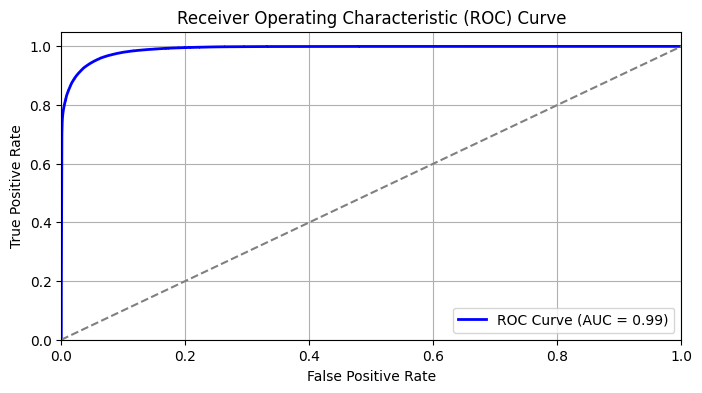

[0]	validation-rmsle:4.16326
[1]	validation-rmsle:4.09779
[2]	validation-rmsle:4.03273
[3]	validation-rmsle:3.96810
[4]	validation-rmsle:3.90390
[5]	validation-rmsle:3.84012
[6]	validation-rmsle:3.77679
[7]	validation-rmsle:3.71389
[8]	validation-rmsle:3.65144
[9]	validation-rmsle:3.58945
[10]	validation-rmsle:3.52791
[11]	validation-rmsle:3.46683
[12]	validation-rmsle:3.40621
[13]	validation-rmsle:3.34607
[14]	validation-rmsle:3.28638
[15]	validation-rmsle:3.22718
[16]	validation-rmsle:3.16845
[17]	validation-rmsle:3.11022
[18]	validation-rmsle:3.05246
[19]	validation-rmsle:2.99521
[20]	validation-rmsle:2.93845
[21]	validation-rmsle:2.88219
[22]	validation-rmsle:2.82642
[23]	validation-rmsle:2.77115
[24]	validation-rmsle:2.71639
[25]	validation-rmsle:2.66213
[26]	validation-rmsle:2.60840
[27]	validation-rmsle:2.55520
[28]	validation-rmsle:2.50253
[29]	validation-rmsle:2.45039
[30]	validation-rmsle:2.39879
[31]	validation-rmsle:2.34774
[32]	validation-rmsle:2.29725
[33]	validation-rmsl

In [346]:
%time dataset, model_classification, model_regression, X_test,y_test = train_full_model(dataset)

### Top features for the classification

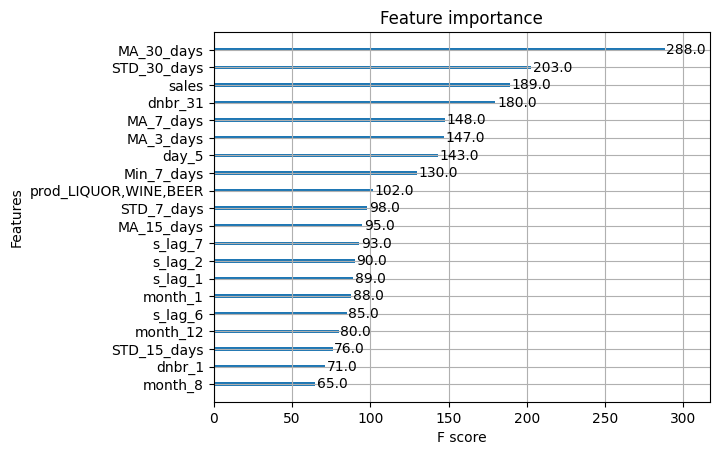

In [347]:
print_feature_importance(model_classification,max_num_features=20)

### Top features for the regression

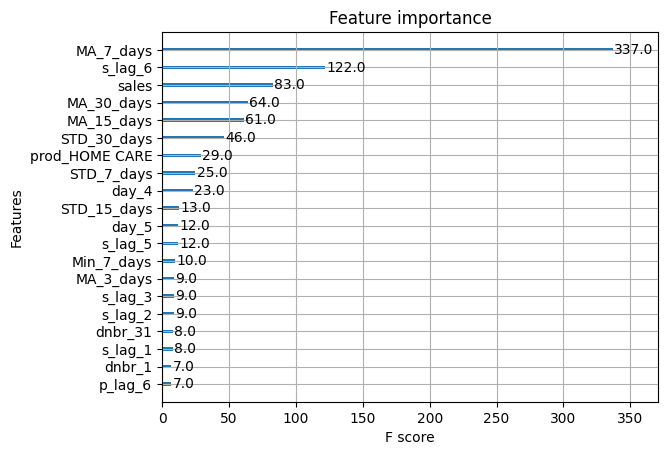

In [348]:
print_feature_importance(model_regression,max_num_features=20)

### Evaluation of combined model

In [349]:
%time  evaluate_full_model(dataset, model_classification, model_regression, X_test,y_test,col_try)

The RMSLE is: 0.54679
CPU times: total: 4.33 s
Wall time: 874 ms


##### To be noted that the moving average on 7 days is a pretty effective model too:

In [350]:
compute_rmsle(dataset['MA_7_days'], dataset['target'])

The RMSLE is: 0.58296


## END

In [366]:
print(len(dataset[dataset['target']==0]) / len(dataset))
print( len(dataset[ (dataset['target']==1)]) / len(dataset) )

0.27428811188811186
0.040424242424242425


<Axes: >

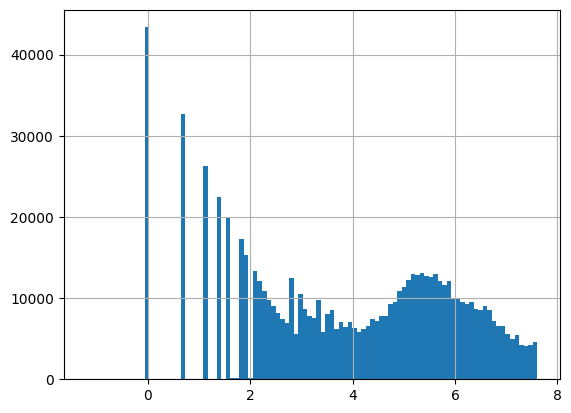

In [361]:
np.log(short[short['target']<2000]['target']).hist(bins = 100)

<Axes: >

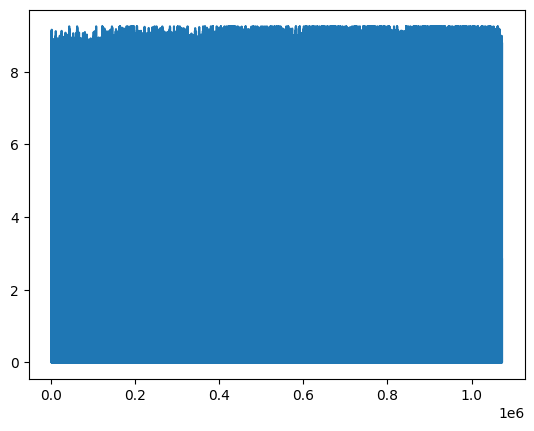

In [353]:
np.log1p(dataset['target']).plot()